In [3]:
!pip install -q pythainlp
!pip install -q stanza

     |████████████████████████████████| 11.0 MB 4.8 MB/s 
     |████████████████████████████████| 743 kB 46.5 MB/s 
     |████████████████████████████████| 432 kB 5.3 MB/s 
     |████████████████████████████████| 170 kB 62.8 MB/s 


In [4]:
import stanza
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import save
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
from pythainlp import word_tokenize

sns.set_theme()

In [ ]:
print("Downloading English and Chinese model...")
stanza.download('en')
stanza.download('zh') 

2021-12-16 19:13:40 INFO: Downloading default packages for language: en (English)...


2021-12-16 19:13:55 INFO: Finished downloading models and saved to /root/stanza_resources.


2021-12-16 19:13:55 INFO: "zh" is an alias for "zh-hans"
2021-12-16 19:13:55 INFO: Downloading default packages for language: zh-hans (Simplified_Chinese)...


2021-12-16 19:14:17 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
th2en_df = pd.read_csv('/content/drive/MyDrive/Final_Datasets/final_crosslingual_sum_datasets/th2en_full.csv', encoding='utf-8')
th2zh_df = pd.read_csv('/content/drive/MyDrive/Final_Datasets/final_crosslingual_sum_datasets/th2zh_full.csv', encoding='utf-8')
test_df = pd.read_csv('/content/drive/MyDrive/Final_Datasets/final_crosslingual_sum_datasets/testset.csv', encoding='utf-8')
validation_df = pd.read_csv('/content/drive/MyDrive/Final_Datasets/final_crosslingual_sum_datasets/validation.csv', encoding='utf-8')

# 1. Data Fields

## 1.1) Thai-to-English Dataset (TH2EN)

In [ ]:
print(f'TH2EN contains: {th2en_df.columns}, with {len(th2en_df)} rows.')
th2en_df.sample(n=3)

TH2EN contains: Index(['th_body', 'th_sum', 'en_body', 'en_sum', 'en2th', 'url'], dtype='object'), with 310926 rows.


,th_body,th_sum,en_body,en_sum,en2th,url
287150,ตำรวจ สภ.นาโยง จ.ตรัง ตรวจสอบที่เกิดเหตุยิงกัน...,เกิดเหตุยิงกันบนถนนเพชรเกษม จ.ตรัง เมื่อช่วงกล...,"Police, security. Na Yong, Chiang Mai Trang ex...",A fire broke out on Petchkasem Road in Trang p...,เหตุไฟไหม้ที่ถนนเพชรเกษม จังหวัดตรัง กลางดึก (...,https://news.thaipbs.or.th/content/252243
1641,สยามบรมราชกุมารี พร้อมเงินรางวัลรวม 1.77 ล้าน...,เปิดเวทีให้เยาวชนไทยได้แสดงความสามารถด้านต่างๆ...,Siam Boromrajakri with a total prize of 1.77 m...,Open the stage for Thai youth to show their ta...,เปิดเวทีให้เยาวชนไทยได้แสดงความสามารถของตนในรู...,https://www.thairath.co.th/lifestyle/life/1403202
221142,เมื่อวันที่ 1 มี.ค. นายพรชัย ฐีระเวช รองผู้อำน...,คลัง ย้ำเปิดลงทะเบียนคนจนรอบใหม่ 3 เม.ย.-15 พ....,"On March 1. c. Mr. Pornchai Theravej, Deputy D...",Archives reiterated the opening of new registr...,หอจดหมายเหตุย้ำเปิดการลงทะเบียนใหม่สำหรับคนยาก...,https://www.thairath.co.th/content/871330


## 1.2) Thai-to-Simplified Chinese Dataset (TH2ZH)

In [7]:
print(f'TH2ZH contains: {th2zh_df.columns}, with {len(th2zh_df)} rows.')
th2zh_df.sample(n=3)

TH2ZH contains: Index(['th_body', 'th_sum', 'zh_body', 'zh_sum', 'zh2th', 'url'], dtype='object'), with 310926 rows.


,th_body,th_sum,zh_body,zh_sum,zh2th,url
163076,การตรวจสอบยาแก้หวัดที่หายจากโรงพยาบาลกมลาไสย จ...,ผู้ต้องสงสัยที่ถูกซัดทอดรับซื้อยาแก้หวัด สูตร...,检查从加拉信省卡马拉赛医院回收的 30 多万片感冒药。 警方发现，至少有 5 名医院工作人员...,从加拉信省 Kamasai 医院药剂师转移到购买一种普通感冒药物的嫌疑人，随着警方打击近 4...,การย้ายจากเภสัชกรที่โรงพยาบาลคามาไซ จังหวัดการ...,https://news.thaipbs.or.th/content/74105
38538,กลุ่มหมอกควันที่เกิดจากไฟป่า บริเวณริมทางหลวง ...,ปัญหาหมอกควันหลายจังหวัดภาคเหนือยังน่าเป็นห่ว...,烟雾引起的公路上的野火。 南-帕府覆盖在该地区。 南已经降低了知名度，即使是艾纳莱分区行政组...,北部许多省份的烟雾问题也令人担忧，尽管空气质量测量显示某些省份的灰尘含量减少，但也发现隐形和...,ปัญหาควันยังเป็นเรื่องกังวลในหลายจังหวัดภาคเหน...,https://news.thaipbs.or.th/content/155169
300884,นายวุฒิชาติ กัลยาณมิตร ผู้ว่าการการรถไฟแห่งประ...,วุฒิชาติ เผย รฟท.จัดรถไฟฟรี 160 ขบวนต่อวัน อำน...,"泰国铁路局长 Wutthicat Kalyanamit 先生透露, 内阁批准将自由铁路措施的...",Wutthachart 公布 SRT 免费 160 列车，每天根据公共行政部之后的国家政策，...,วุฒิชาตเผยแพร่รถไฟฟรี 160 ขบวน ซึ่งอำนวยความสะ...,https://www.thairath.co.th/content/539250


## 1.3) Validation Set

In [ ]:
print(f'Validation set contains: {validation_df.columns}, with {len(validation_df )} rows.')
validation_df.sample(n=2)

Validation set contains: Index(['th_body', 'th_sum', 'en_body', 'en_sum', 'zh_body', 'zh_sum', 'en2th',
       'zh2th', 'en_gg_sum', 'zh_gg_sum', 'url'],
      dtype='object'), with 3000 rows.


,th_body,th_sum,en_body,en_sum,zh_body,zh_sum,en2th,zh2th,en_gg_sum,zh_gg_sum,url
1384,หากพูดถึงละครรสแซ่บนาทีนี้ต้องยกให้ละครเรื่อง ...,หากพูดถึงละครรสแซ่บนาทีนี้ต้องยกให้ละครเรื่อง ...,"If you talk about this delicious drama, you ha...","If you talk about this miniseries, you have to...",如果你谈论这个美味的戏剧，你必须给电视剧 “斯瓦特” 8 频道，那里的屏幕是激烈的戏剧一代代...,如果你谈论这个短剧，你必须给电视剧 “特警” 8 频道，其中屏幕是激烈的戏剧，从一代代。,หากพูดถึงกระทรวงนี้ ต้องให้ละครเรื่อง “สวาท” ท...,หากพูดถึงบทละครนี้ต้องมอบละครโทรทัศน์เรื่อง “ส...,"If talking about a hot taste drama, this minut...",如果要在这一分钟谈论热辣的戏剧，则必须在第8频道播出电视剧“ Ruea Saisawad”，...,https://www.thairath.co.th/entertain/news/1776470
333,กรมอนามัยชูวิถีใหม่กันเชื้อ แย้มสัปดาห์หน้าปลด...,วิษณุ สะอึก เห็นคนแห่เที่ยวบางแสน กระทบแผนผ่อน...,The Department of Health prevented the infecti...,"Vishnu Sauk saw people flocking to Bang Saen, ...",卫生署预防感染下周四期纳龙柴威胁要关闭几十万海滩旅行和 6 做法的游客纳龙柴昆伦。 如果游客...,维什努·索克看到人们涌向 Bang Saen，影响了 4 期间的计划和 B.E. 答：紧急情...,พระวิษณุสุขเห็นคนแห่กันไปบางแสน กระทบแผนช่วงที...,พระวิษณุถุงเท้าเห็นคนแห่กันไปบางแสน กระทบต่อแผ...,Vishnu hiccup to see people flocking to Bangsa...,毗湿奴打ic看到人们涌向Bangsaen 影响4个月的分期付款计划和紧急法令 至于泼水节，没...,https://www.thairath.co.th/news/local/1862239


## 1.4) Test Set

In [ ]:
print(f'test set contains: {test_df.columns}, with {len(test_df )} rows.')
test_df.sample(n=2)

test set contains: Index(['th_body', 'th_sum', 'en_body', 'en_sum', 'zh_body', 'zh_sum', 'en2th',
       'zh2th', 'en_gg_sum', 'zh_gg_sum', 'th_title', 'en_title', 'zh_title',
       'url'],
      dtype='object'), with 3000 rows.


,th_body,th_sum,en_body,en_sum,zh_body,zh_sum,en2th,zh2th,en_gg_sum,zh_gg_sum,th_title,en_title,zh_title,url
462,สั่งทีมซักฟอก ปชป.ไล่ขยี้ภท. รับผิด กดบัตรป้อง...,สนธิรัตน์ รอ ชวน ชี้ ขาดผลสอบ ส.ส.รัฐบาลกดบัตร...,Order a DEA washing team. Chasing down the wor...,Sookrat Roo Chuan pointed out the lack of test...,订购一个 DEA 洗衣队。 追逐世界 责任按早期保护卡有关没有意图打倒 63 Nipit 的...,苏克拉特鲁川指出缺乏测试结果。 星期六。 政府在整个议会会议室的生日派对上按了可互换卡。 重...,สุขรัตน์ รูชวนชี้ให้เห็นว่าขาดผลการทดสอบ ส. รั...,สุคราตลุชนชี้ว่าขาดผลการทดสอบ ในปี พ. วันเสาร์...,Sonthirat awaits to suggest the lack of examin...,桑西拉特（Sonthirat）等待提出缺乏考试结果的建议，政府议员则改为按要求出示证件。 在...,รุมกินโต๊ะบิ๊กตู่ แผนเพื่อไทยเล่นให้น่วม,Swarm around Big Tu Plans for Thailand to play...,群聚大屠杀泰国计划一起玩,https://www.thairath.co.th/news/politic/1756895
252,สาวใหญ่วัย 40 ที่พิษณุโลก ออกโรงแทนเพื่อน ตบตี...,สาวใหญ่วัย 40 ที่พิษณุโลก ออกโรงแทนเพื่อน ตบตี...,Big girl in 40 years at Phitsanulok instead of...,Big girl in 40 years at Phitsanulok instead of...,大女孩在 40 年在彭世洛，而不是她的朋友。g. 14 岁后一个朋友聊天聊天，而孩子不想任何...,大女孩在 40 年在彭世洛，而不是她的朋友。g. 14 岁后，他的朋友聊天聊天，而孩子什么都...,สาวใหญ่ในรอบ 40 ปี ที่พิษณุโลกแทนเพื่อน กรัม อ...,สาวใหญ่ในรอบ 40 ปีที่จังหวัดพิษณุโลก ไม่ใช่เพื...,A 40-year-old girl in Phitsanulok premiere on ...,一位丈夫聊天后，一名40岁女孩在彭世洛代表14岁的女友首映。 孩子说话的时候，他什么也没想。...,สาวใหญ่วัย 40 ออกโรงแทน ตบตี ด.ญ.วัย 14 หลังผั...,40-year-old girl premiere instead of slapping ...,40岁的女孩首映，而不是在与丈夫聊天后对14岁的女孩打耳光,https://www.thairath.co.th/news/society/1763743


# 2. Word Count Distribution

In [ ]:
zh_nlp = stanza.Pipeline('zh', processors='tokenize', verbose=False, use_gpu=True)
en_nlp = stanza.Pipeline('en', processors='tokenize', verbose=False, use_gpu=True)

def tokenize_zh(text):
  zh_doc = zh_nlp(text)
  tokenized_words = []
  for i, sent in enumerate(zh_doc.sentences):
    for word in sent.words:
      tokenized_words.append(word.text)   
  return {'num_words': zh_doc.num_words, 'tokenized_text': tokenized_words}

def tokenize_en(text):
  en_doc = en_nlp(text)
  tokenized_words = []
  for i, sent in enumerate(en_doc.sentences):
    for word in sent.words:
      tokenized_words.append(word.text)   
  return  {'num_words': en_doc.num_words, 'tokenized_text': tokenized_words}

def tokenize_th(text):
  th_doc = word_tokenize(text, keep_whitespace=False)
  return {'num_words': len(th_doc), 'tokenized_text': th_doc}

In [ ]:
th_body_wc_train = []
zh_body_wc_train = []
en_body_wc_train = []
th_sum_wc_train = []
zh_sum_wc_train = []
en_sum_wc_train = []

for index, row in tqdm(th2en_df.iterrows(), total=th2en_df.shape[0]):
  th_body_wc_train.append(tokenize_th(row['th_body'])['num_words'])
  zh_body_wc_train.append(tokenize_zh(th2zh_df.iloc[index]['zh_body'])\
                          ['num_words'])
  en_body_wc_train.append(tokenize_en(row['en_body'])['num_words'])

  th_sum_wc_train.append(tokenize_th(row['th_sum'])['num_words'])
  zh_sum_wc_train.append(tokenize_zh(th2zh_df.iloc[index]['zh_sum'])\
                          ['num_words'])
  en_sum_wc_train.append(tokenize_en(row['th_sum'])['num_words'])
  
save('th_body.npy', np.array(th_body_wc_train))
save('zh_body.npy', np.array(zh_body_wc_train))
save('en_body.npy', np.array(en_body_wc_train))
save('th_sum.npy', np.array(th_sum_wc_train))
save('zh_sum.npy', np.array(zh_sum_wc_train))
save('en_sum.npy', np.array(en_sum_wc_train))

  0%|          | 0/310926 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## 2.1) Word count distribution of `{th/en/zh}_body`



In [10]:
train_th_body = np.load('/content/th_body.npy')
train_th_sum = np.load('/content/th_sum.npy')
train_en_body = np.load('/content/en_body.npy')
train_en_sum = np.load('/content/en_sum.npy')
train_zh_body = np.load('/content/zh_body.npy')
train_zh_sum = np.load('/content/zh_sum.npy')

validation_wc_df = pd.read_csv('/content/validation_wc.csv')
test_wc_df = pd.read_csv('/content/testset_wc.csv')

These numpy files and csv files can be downloaded at [https://drive.google.com/drive/folders/1ksJn41TWZHzektJRD0LfHvj4jRtO73Gy](https://drive.google.com/drive/folders/1ksJn41TWZHzektJRD0LfHvj4jRtO73Gy?usp=sharing).

In [11]:
test_wc_df.sample(n=3)

,th_body,th_sum,en_body,en_sum,zh_body,zh_sum,en_gg_sum,zh_gg_sum,th_title,en_title,zh_title,url
2514,370.0,29.0,474.0,46.0,334.0,39.0,45.0,37.0,15.0,18.0,17.0,https://www.thairath.co.th/news/society/1777601
2198,308.0,29.0,285.0,35.0,257.0,33.0,34.0,28.0,14.0,13.0,14.0,https://www.thairath.co.th/entertain/news/1815616
1216,1947.0,33.0,1555.0,29.0,1424.0,27.0,34.0,28.0,19.0,21.0,17.0,https://www.thairath.co.th/news/auto/news/1777063


In [ ]:
validation_wc_df.sample(n=3)

,th_body,th_sum,en_body,en_sum,zh_body,zh_sum,url
77,355.0,48.0,348.0,54.0,307.0,41.0,https://www.thairath.co.th/news/local/north/18...
2356,776.0,27.0,639.0,21.0,590.0,15.0,https://www.thairath.co.th/news/society/1796313
2213,472.0,21.0,422.0,19.0,385.0,27.0,https://www.thairath.co.th/entertain/news/1836624


(0.0, 1200.0)

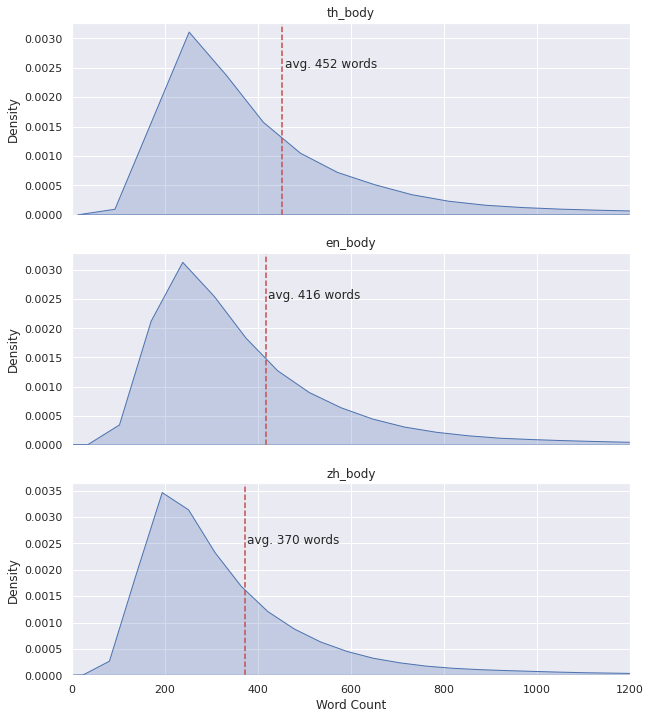

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axes[0].set_title('th_body')
sns.kdeplot(train_th_body, shade=True, ax=axes[0], label="Train")
axes[0].axvline(np.average(train_th_body), color='r', linestyle='--')
axes[0].text(np.average(train_th_body) + 5, 0.0025, f'avg. {int(np.average(train_th_body))} words')

axes[1].set_title('en_body')
sns.kdeplot(train_en_body, shade=True, ax=axes[1])
axes[1].axvline(np.average(train_en_body), color='r', linestyle='--')
axes[1].text(np.average(train_en_body) + 5, 0.0025, f'avg. {int(np.average(train_en_body))} words')

axes[2].set_title('zh_body')
sns.kdeplot(train_zh_body, shade=True, ax=axes[2])
axes[2].axvline(np.average(train_zh_body), color='r', linestyle='--')
axes[2].text(np.average(train_zh_body) + 5, 0.0025, f'avg. {int(np.average(train_zh_body))} words')

plt.xlabel("Word Count")
plt.xlim(0,1200)

## 2.2) Word count distribution of `{th/en/zh}_sum`

(0.0, 150.0)

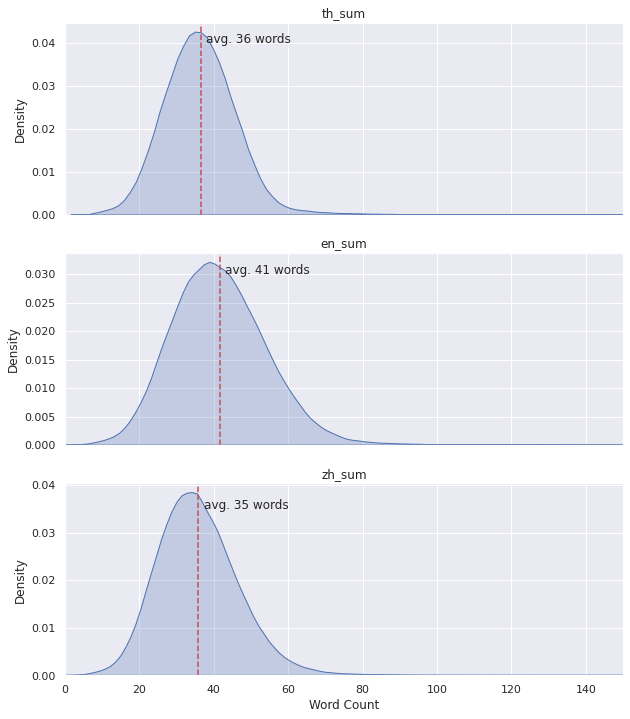

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

axes[0].set_title('th_sum')
sns.kdeplot(train_th_sum, shade=True, ax=axes[0])
axes[0].axvline(np.average(train_th_sum), color='r', linestyle='--')
axes[0].text(np.average(train_th_sum) + 1.5, 0.04, f'avg. {int(np.average(train_th_sum))} words')

axes[1].set_title('en_sum')
sns.kdeplot(train_en_sum, shade=True, ax=axes[1])
axes[1].axvline(np.average(train_en_sum), color='r', linestyle='--')
axes[1].text(np.average(train_en_sum) + 1.5, 0.03, f'avg. {int(np.average(train_en_sum))} words')

axes[2].set_title('zh_sum')
sns.kdeplot(train_zh_sum, shade=True, ax=axes[2])
axes[2].axvline(np.average(train_zh_sum), color='r', linestyle='--')
axes[2].text(np.average(train_zh_sum) + 1.5, 0.035, f'avg. {int(np.average(train_zh_sum))} words')

plt.xlabel("Word Count")
plt.xlim(0,150)

## 2.3) Word Counts of Test and Validation Sets

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['', 'Validation', 'Test']
x.add_row(['th_body', int(validation_wc_df['th_body'].mean()), int(test_wc_df['th_body'].mean())])
x.add_row(['en_body', int(validation_wc_df['en_body'].mean()), int(test_wc_df['en_body'].mean())])
x.add_row(['zh_body', int(validation_wc_df['zh_body'].mean()), int(test_wc_df['zh_body'].mean())])
x.add_row(['th_sum', int(validation_wc_df['th_sum'].mean()), int(test_wc_df['th_sum'].mean())])
x.add_row(['en_sum', int(validation_wc_df['en_sum'].mean()), int(test_wc_df['en_sum'].mean())])
x.add_row(['zh_sum', int(validation_wc_df['zh_sum'].mean()), int(test_wc_df['zh_sum'].mean())])
x.add_row(['en_gg_sum', 'N/A', int(test_wc_df['en_gg_sum'].mean())])
x.add_row(['zh_gg_sum', 'N/A', int(test_wc_df['zh_gg_sum'].mean())])
x.add_row(['th_title', 'N/A', int(test_wc_df['th_title'].mean())])
x.add_row(['en_title', 'N/A', int(test_wc_df['en_title'].mean())])
x.add_row(['zh_title', 'N/A', int(test_wc_df['zh_title'].mean())])

print(x)

+-----------+------------+------+
|           | Validation | Test |
+-----------+------------+------+
|  th_body  |    555     | 554  |
|  en_body  |    517     | 513  |
|  zh_body  |    460     | 457  |
|   th_sum  |     34     |  34  |
|   en_sum  |     37     |  37  |
|   zh_sum  |     34     |  34  |
| en_gg_sum |    N/A     |  40  |
| zh_gg_sum |    N/A     |  36  |
|  th_title |    N/A     |  15  |
|  en_title |    N/A     |  19  |
|  zh_title |    N/A     |  17  |
+-----------+------------+------+


## 2.3) Translation Length Difference between Our Main Translation Service VS. Google Translation 

Google Translation generally generated longer translation than the main translation service that we used.

### TH2EN

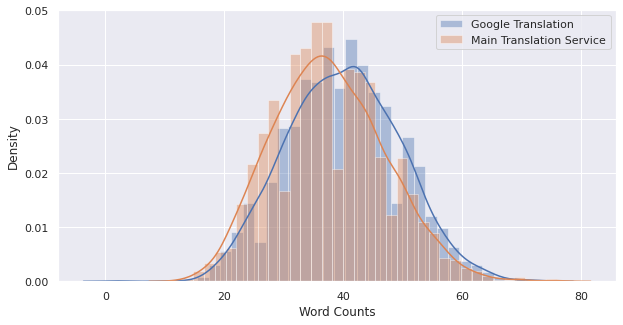

In [39]:
fig, ax = plt.subplots(figsize=[10, 5])
ax = sns.distplot(test_wc_df['en_gg_sum'], label='Google Translation')
ax = sns.distplot(test_wc_df['en_sum'], label='Main Translation Service')
plt.xlabel('Word Counts')
plt.legend() 

### TH2ZH

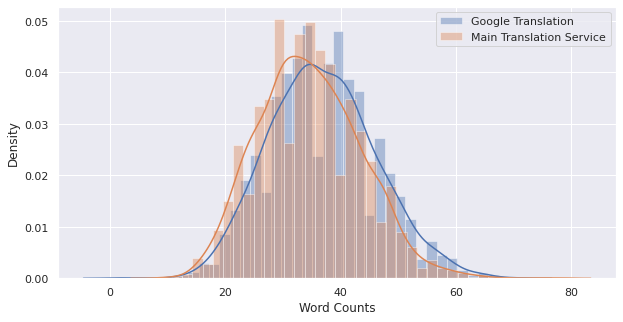

In [40]:
fig, ax = plt.subplots(figsize=[10, 5])
ax = sns.distplot(test_wc_df['zh_gg_sum'], label='Google Translation')
ax = sns.distplot(test_wc_df['zh_sum'], label='Main Translation Service')
plt.xlabel('Word Counts')
plt.legend() 